## Part 2: Nearest-neighbor classification
<a id=part2></a>

In this part, we'll familiarize ourselves with the `PyTorch` tensor API by implementing a very simple classifier,
kNN, using efficient, vectorized tensor operations alone.
We'll then implement cross-validation, an important ML technique used to find suitable
values for a model's hyperparameters.

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

### kNN Classification
<a id=part2_1></a>

Arguably the most basic classification scheme in a supervised learning setting is the
`k` nearest-neighbor (kNN) classifier.
Given a training data set, kNN's "training" phase consists of simply **memorizing** it.
When a classification of an unseen sample is required, some distance metric (e.g. euclidean)
is computed from all training samples.
The unseen sample is then classified according to the majority label of it's `k` nearest-neighbors.

Here we'll implement the most basic kNN, working directly on image pixel values and computing L2 distance
between a test image and every known training image.
We'll use data from the [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits.
This database contains single-channel images with a constant black background and the digits are
roughly the same size, which makes it feasible to obtain bearable classification accuracy even with
such a naïve model.

Note however that real-world KNN model are often implemented with tree-based data structures to
find nearest neighbors in logarithmic time, specialized distance functions and
using image features instead of raw pixels.

**TODO** Implement the `TensorView` transform in the `hw1/transforms` module, and run the following code to
load the data we'll work with.

In [2]:
# Prepare data for kNN Classifier
import torchvision.transforms as tvtf

import cs236781.dataloader_utils as dataloader_utils
import hw1.datasets as hw1datasets
import hw1.transforms as hw1tf

# Define the transforms that should be applied to each CIFAR-10 image before returning it
tf_ds = tvtf.Compose([
    tvtf.ToTensor(), # Convert PIL image to pytorch Tensor
    hw1tf.TensorView(-1), # Reshape to 1D Tensor
])

# Define how much data to load (only use a subset for speed)
num_train = 10000
num_test = 1000
batch_size = 1024

# Training dataset & loader
data_root = os.path.expanduser('~/.pytorch-datasets')
ds_train = hw1datasets.SubsetDataset(
    torchvision.datasets.MNIST(root=data_root, download=True, train=True, transform=tf_ds), num_train)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size)

# Test dataset & loader
ds_test = hw1datasets.SubsetDataset(
    torchvision.datasets.MNIST(root=data_root, download=True, train=False, transform=tf_ds), num_test)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

# Get all test data
x_test, y_test = dataloader_utils.flatten(dl_test)

**TODO** Implement the `l2_dist` function in the `hw1/knn_classifier.py` module. This is the core of the kNN algorithm. You'll need to use broadcasting to implement it in an efficient, vectorized way (without loops).

In [3]:
import itertools as it
import hw1.knn_classifier as hw1knn

def l2_dist_naive(x1, x2):
    """
    Naive distance calculation, just for testing.
    Super slow, don't use!
    """
    dists = torch.empty(x1.shape[0], x2.shape[0], dtype=torch.float)
    for i, j in it.product(range(x1.shape[0]), range(x2.shape[0])):
        dists[i,j] = torch.sum((x1[i] - x2[j])**2).item()
    return torch.sqrt(dists)


# Test distance calculation
x1 = torch.randn(12, 34)
x2 = torch.randn(45, 34)

dists = hw1knn.l2_dist(x1, x2)
dists_naive = l2_dist_naive(x1, x2)

test.assertTrue(torch.allclose(dists, dists_naive), msg="Wrong distances")

**TODO** Implement the `accuracy` function in the `hw1/knn_classifier.py` module.
This will be our score. It will simply return the fraction of predictions that are correct.

In [4]:
y1 = torch.tensor([0, 1, 2, 3])
y2 = torch.tensor([2, 2, 2, 2])

test.assertEqual(hw1knn.accuracy(y1, y2), 0.25)

**TODO** Complete the implementation of the `KNNClassifier` class in the module `hw1/knn_classifier.py`:
1. Implement the kNN "training" in the `train()` method.
1. Implement label prediction in the `predict()` method.

Use the following code to test your implementations.

In [5]:
# Test kNN Classifier
knn_classifier = hw1knn.KNNClassifier(k=10)
knn_classifier.train(dl_train)
y_pred = knn_classifier.predict(x_test)

# Calculate accuracy
accuracy = hw1knn.accuracy(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Sanity check: at least 80% accuracy
test.assertGreater(accuracy, 0.8)

Accuracy: 91.50%


### Cross-validation
<a id=part2_2></a>

A common way to  choose hyperparameters for a model or even the model itself is by applying
**K-fold cross-validation** (CV).
For each candidate set of hyperparameters, the model is trained `K` times, each time with a different split of the training data to train and validation sets (called a fold). The set of hyperparameters which resulted in the the lowest average validation error rate is selected.

More specifically, K-fold CV is usually performed as follows:

1. For all choices of a model and/or set of hyperparameters for the model:
    1. Split training set into `K` non-overlapping parts. 
    1. For `k=0,...,K-1`:
        1. Select the `k`-th part as the validation set and the remaining `k-1` parts as the training set.
        1. Train the current model on the current training set.
        1. Evaluate the model on the current validation set to obtain it's validation error.
    1. Calculate current model's average validation error accross the K folds.
1. Select the model with the lowest average validation error.
1. Train the selected model with the entire training set.
1. Evaluate the model with the test set.

Now we would like to find the best value of K for applying our kNN model to CIFAR-10.
In this case we already fixed the model and there is only one hyperparameter, the value of `k`
(not to be confused with `K`, the number of folds for the cross validation).

**TODO** Complete the implementation of the `find_best_k` function in the `knn_classifier.py` module.

In [6]:
num_folds = 4
k_choices = [1, 3, 5, 8, 12, 20, 50]

# Run cross-validation
best_k, accuracies = hw1knn.find_best_k(ds_train, k_choices, num_folds)

best_k = 3


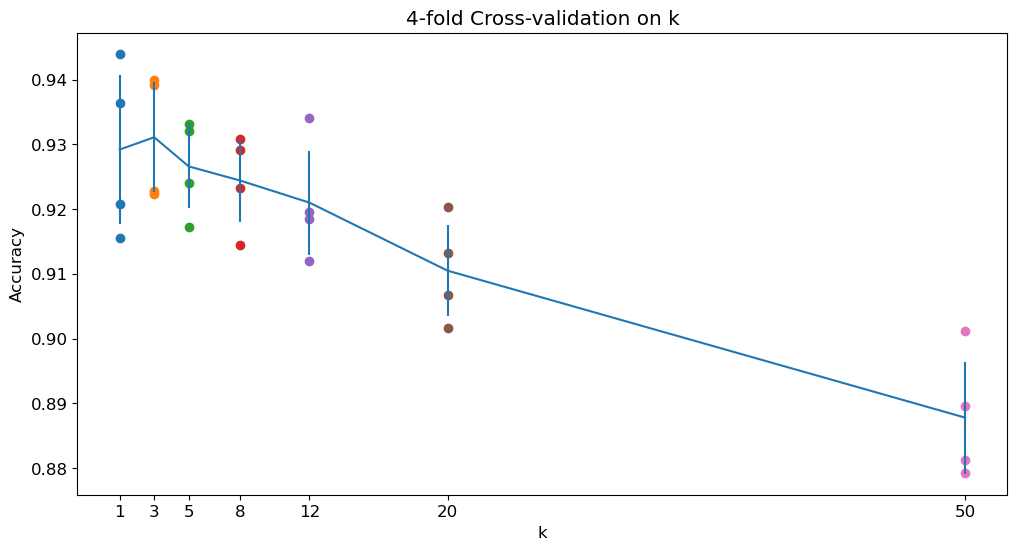

In [7]:
# Plot accuracies per k
_, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(xticks=k_choices))
for i, k in enumerate(k_choices):
    curr_accuracies = accuracies[i]
    ax.scatter([k] * len(curr_accuracies), curr_accuracies)

accuracies_mean = np.array([np.mean(accs) for accs in accuracies])
accuracies_std = np.array([np.std(accs) for accs in accuracies])
ax.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
ax.set_title(f'{num_folds}-fold Cross-validation on k')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')

print('best_k =', best_k)

Now that we found our `best_k`, we can train the model with that value of `k` on the full training set and evaluate the accuracy on the test set:

In [8]:
knn_classifier = hw1knn.KNNClassifier(k=best_k)
knn_classifier.train(dl_train)
y_pred = knn_classifier.predict(x_test)

# Calculate accuracy
accuracy_best_k = hw1knn.accuracy(y_test, y_pred)
print(f'Accuracy: {accuracy_best_k*100:.2f}%')

test.assertGreater(accuracy_best_k, accuracy)

Accuracy: 91.90%


### Questions

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw1/answers.py`.

In [9]:
from cs236781.answers import display_answer
import hw1.answers

#### Question 1

Does increasing `k` lead to improved generalization for unseen data? Why or why not? Up to what point? Think about the extremal values of `k`.

In [10]:
display_answer(hw1.answers.part2_q1)


**Your answer:**

Increasing k can improve generalization of unseen data. As an example, in or model, we can see that increasing k up to k=3 improved the generalization. Increasing k further will result in an inaccurate model. This is because our estimation is influenced by further unrelated samples and their share in the total dataset.



#### Question 2

Explain why (i.e. in what sense) using k-fold CV, as detailed above, is better than:
1. Training on the entire train-set with various models and selecting the best model with respect to **train-set** accuracy.
2. Training on the entire train-set with various models and selecting the best model with respect to **test-set** accuracy.

In [11]:
display_answer(hw1.answers.part2_q2)


**Your answer:**

1. Training on the entire train-set with various models and selecting the best model with respect to **train-set** accuracy.
Using k-fold CV we can get better estimation of the generalization of our model on unseen data, where in selecting the best model with respect to train set accuracy we can pick the model which over fit our train set the most but is unreliable for unseen data.

2. Training on the entire train-set with various models and selecting the best model with respect to **test-set** accuracy.
In k-fold CV we are using different fold in each training to validate our accuracy results.
And then taking the average or the mean of all accuracies. By doing this, our cross validation is less sensitive to train test traditional splits of data. For example, we can pick samples for testing the model which gives great results, choose the model and call it a day.

